In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import pyparsing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [2]:
##select dir
import os
os.getcwd()
data_dir = Path("/ibex/scratch/medinils/breast_data/data/")

##load the data
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir / "supplementary_data/test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


In [3]:
####DATA PROCESSING####

X_train = []
y_train = []
centers_train = []
patients_train = []


for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(np.mean(features, axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)


100%|██████████| 344/344 [00:02<00:00, 158.46it/s]


Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers
AUC on split 0 fold 0: 0.590
AUC on split 0 fold 1: 0.490
AUC on split 0 fold 2: 0.673
AUC on split 0 fold 3: 0.705
AUC on split 0 fold 4: 0.536
----------------------------
AUC on split 1 fold 0: 0.695
AUC on split 1 fold 1: 0.667
AUC on split 1 fold 2: 0.498
AUC on split 1 fold 3: 0.502
AUC on split 1 fold 4: 0.558
----------------------------
AUC on split 2 fold 0: 0.568
AUC on split 2 fold 1: 0.730
AUC on split 2 fold 2: 0.593
AUC on split 2 fold 3: 0.524
AUC on split 2 fold 4: 0.517
----------------------------
AUC on split 3 fold 0: 0.718
AUC on split 3 fold 1: 0.661
AUC on split 3 fold 2: 0.535
AUC on split 3 fold 3: 0.471
AUC on split 3 fold 4: 0.447
----------------------------
AUC on split 4 fold 0: 0.563
AUC on split 4 fold 1: 0.535
AUC on split 4 fold 2: 0.697
AUC on split 4 fold 3: 0.455
AUC on split 4 fold 4: 0.607
----------------------------
5-fold cross-valid

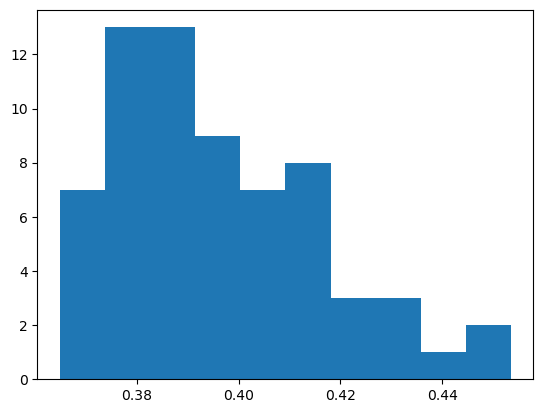

In [4]:
###5-fold cross validation####
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split
patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)


aucs = []
lrs = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        #
        #train_idx = np.array(train_idx)
        #assert train_idx.ndim == 1
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        lr = LogisticRegression(C=0.01, solver="liblinear")
        # fit it
        lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = lr.predict_proba(X_fold_val)[:, 1]

        # Predictions on training data
        preds_train = lr.predict_proba(X_fold_train)[:, 1]

        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        lrs.append(lr)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)


plt.hist(preds_val)
plt.show()

In [10]:
# ... [Previous code remains unchanged]
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score

# Initialize lists to store training AUCs and validation AUCs
train_aucs = []
val_aucs = []
precision_scores = []

# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # ... [Previous splitting code remains unchanged]

        # instantiate the model
        lr = LogisticRegression(C=0.01, solver="liblinear")
        # fit it
        lr.fit(X_fold_train, y_fold_train)

        # Predictions on training data
        preds_train = lr.predict_proba(X_fold_train)[:, 1]
        train_auc = roc_auc_score(y_fold_train, preds_train)

        # Predictions on validation data
        preds_val = lr.predict_proba(X_fold_val)[:, 1]
        val_auc = roc_auc_score(y_fold_val, preds_val)

        # Store precision scores for both training and validation
        precision_train = precision_score(y_fold_train, (preds_train > 0.5).astype(int))
        precision_val = precision_score(y_fold_val, (preds_val > 0.5).astype(int))



        print(f"Train AUC on split {k} fold {fold}: {train_auc:.3f}")
        print(f"Validation AUC on split {k} fold {fold}: {val_auc:.3f}")
        print("----------------------------")

        # Store the AUCs
        train_aucs.append(train_auc)
        val_aucs.append(val_auc)
        precision_scores.append(precision_val)

        fold += 1

# Display final average AUCs for training and validation data
print(
    f"Average train AUC over {k+1} repeats: {np.mean(train_aucs):.3f} ± {np.std(train_aucs):.3f}"
)
print(
    f"Average validation AUC over {k+1} repeats: {np.mean(val_aucs):.3f} ± {np.std(val_aucs):.3f}"
)
print(
    f"Average validation precision over {k+1} repeats: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}"
)


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Train AUC on split 0 fold 0: 0.735
Validation AUC on split 0 fold 0: 0.607
----------------------------
Train AUC on split 0 fold 1: 0.735
Validation AUC on split 0 fold 1: 0.607
----------------------------
Train AUC on split 0 fold 2: 0.735
Validation AUC on split 0 fold 2: 0.607
----------------------------


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Train AUC on split 0 fold 3: 0.735
Validation AUC on split 0 fold 3: 0.607
----------------------------
Train AUC on split 0 fold 4: 0.735
Validation AUC on split 0 fold 4: 0.607
----------------------------


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Train AUC on split 1 fold 0: 0.735
Validation AUC on split 1 fold 0: 0.607
----------------------------
Train AUC on split 1 fold 1: 0.735
Validation AUC on split 1 fold 1: 0.607
----------------------------
Train AUC on split 1 fold 2: 0.735
Validation AUC on split 1 fold 2: 0.607
----------------------------
Train AUC on split 1 fold 3: 0.735
Validation AUC on split 1 fold 3: 0.607
----------------------------


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Train AUC on split 1 fold 4: 0.735
Validation AUC on split 1 fold 4: 0.607
----------------------------
Train AUC on split 2 fold 0: 0.735
Validation AUC on split 2 fold 0: 0.607
----------------------------
Train AUC on split 2 fold 1: 0.735
Validation AUC on split 2 fold 1: 0.607
----------------------------
Train AUC on split 2 fold 2: 0.735
Validation AUC on split 2 fold 2: 0.607
----------------------------


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Train AUC on split 2 fold 3: 0.735
Validation AUC on split 2 fold 3: 0.607
----------------------------
Train AUC on split 2 fold 4: 0.735
Validation AUC on split 2 fold 4: 0.607
----------------------------


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Train AUC on split 3 fold 0: 0.735
Validation AUC on split 3 fold 0: 0.607
----------------------------
Train AUC on split 3 fold 1: 0.735
Validation AUC on split 3 fold 1: 0.607
----------------------------
Train AUC on split 3 fold 2: 0.735
Validation AUC on split 3 fold 2: 0.607
----------------------------
Train AUC on split 3 fold 3: 0.735
Validation AUC on split 3 fold 3: 0.607
----------------------------
Train AUC on split 3 fold 4: 0.735
Validation AUC on split 3 fold 4: 0.607
----------------------------


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Train AUC on split 4 fold 0: 0.735
Validation AUC on split 4 fold 0: 0.607
----------------------------
Train AUC on split 4 fold 1: 0.735
Validation AUC on split 4 fold 1: 0.607
----------------------------
Train AUC on split 4 fold 2: 0.735
Validation AUC on split 4 fold 2: 0.607
----------------------------
Train AUC on split 4 fold 3: 0.735
Validation AUC on split 4 fold 3: 0.607
----------------------------
Train AUC on split 4 fold 4: 0.735
Validation AUC on split 4 fold 4: 0.607
----------------------------
Average train AUC over 5 repeats: 0.735 ± 0.000
Average validation AUC over 5 repeats: 0.607 ± 0.000
Average validation precision over 5 repeats: 0.000 ± 0.000


/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m